# TOPS-Gate: Topology-Preserving Learned Compute Gating (Reference Notebook)
This notebook is a runnable **reference implementation** of the TOPS-Gate idea for **extremely sparse 3D microscopy volumes**.

**What you get here**
- A toy sparse 3D volume generator (tubes/filaments) to validate the method end-to-end.
- A TOPS-Gate PyTorch model:
  - occupancy network `p_φ(x)`
  - intensity decoder `f_θ(x, z_b)` with **brick codes**
  - straight-through **hard gate** `m(x)`
- Adaptive sampling (foreground / boundary / background) driven by the learned gate.
- A simple topology regularizer (graph-Laplacian connectivity surrogate) + optional skeleton-tube prior hooks.
- Export to sparse bricks and render MIP images with empty-brick skipping.

If you want this notebook adapted to your real data loader (e.g., `.tif` stacks) and your camera model, replace the toy generator with your data and keep the training loop unchanged.


## 0. Environment
This notebook uses PyTorch. It runs on CPU or CUDA. If CUDA is available it will use it automatically.

In [1]:
import os, math, random
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


## 1. Toy sparse 3D microscopy volume generator
We create a synthetic volume composed of thin tubes (neurite-like) inside a large empty background.

You can later replace `make_toy_volume()` with a loader for your microscopy `.tif` stacks.

In [3]:
# Load real microscopy volume instead of toy volume
import tifffile

# Load the cropped corrected volume
volume_path = "../../../data/dataset/10-2900-control-cell-05_cropped_corrected.tif"
V_np = tifffile.imread(volume_path).astype(np.float32)

# Normalize to [0, 1]
V_np = (V_np - V_np.min()) / (V_np.max() - V_np.min() + 1e-8)

# Create binary mask (threshold at 0.10)
M_np = (V_np > 0.10).astype(np.uint8)

print(f"Volume path: {volume_path}")
print(f"Volume shape: {V_np.shape}, dtype: {V_np.dtype}")
print(f"Value range: [{V_np.min():.3f}, {V_np.max():.3f}]")
print(f"Occupied %: {100.0*M_np.mean():.2f}%")

Volume path: ../../../data/dataset/10-2900-control-cell-05_cropped_corrected.tif
Volume shape: (100, 647, 813), dtype: float32
Value range: [0.000, 1.000]
Occupied %: 16.18%


### Quick sanity visualization (MIP)

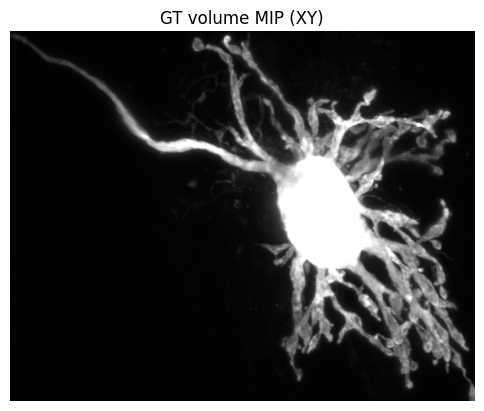

In [5]:
import matplotlib.pyplot as plt

def mip_xy(V):
    # max over z
    return V.max(axis=0)

plt.figure()
plt.imshow(mip_xy(V_np), cmap="gray")
plt.title("GT volume MIP (XY)")
plt.axis("off")
plt.show()


## 2. Coordinate utilities
We train continuous functions over normalized coordinates \(x\in[0,1]^3\).
We sample points and query ground truth via trilinear sampling from the dense grid.

In [6]:
def normalize_coords(ixyz: torch.Tensor, shape: Tuple[int,int,int]) -> torch.Tensor:
    """Convert voxel coordinates (x,y,z) in [0..H-1/W-1/D-1] to normalized [0,1]."""
    H, W, D = shape
    out = ixyz.clone()
    out[..., 0] = out[..., 0] / (H - 1)
    out[..., 1] = out[..., 1] / (W - 1)
    out[..., 2] = out[..., 2] / (D - 1)
    return out

def denormalize_coords(x: torch.Tensor, shape: Tuple[int,int,int]) -> torch.Tensor:
    H, W, D = shape
    out = x.clone()
    out[..., 0] = out[..., 0] * (H - 1)
    out[..., 1] = out[..., 1] * (W - 1)
    out[..., 2] = out[..., 2] * (D - 1)
    return out

def trilinear_sample_volume(V: torch.Tensor, x01: torch.Tensor) -> torch.Tensor:
    """Trilinear sample dense volume V (H,W,D) at normalized coords x01 (N,3) in [0,1]."""
    # grid_sample expects (N,C,D,H,W) and coords (N, outD, outH, outW, 3) in [-1,1] with order (x,y,z) for W,H,D
    # We'll adapt by reshaping to a 1x1xD xH xW tensor and sampling N points.
    H, W, D = V.shape
    V5 = V.permute(2,0,1).unsqueeze(0).unsqueeze(0)  # (1,1,D,H,W)
    grid = x01.clone()
    # convert [0,1] -> [-1,1]
    grid = grid*2.0 - 1.0
    # grid_sample expects (x, y, z) = (W, H, D). Our x01 is (x,y,z) = (H,W,D) indices.
    # Swap to (y,x,z) mapping to (W,H,D)?? Let's define:
    # - V5 is indexed as (D,H,W) => coords are (W,H,D) = (col,row,depth).
    # Our x01 components: (x=row/H, y=col/W, z=depth/D). So to match grid_sample:
    #   grid_sample x = y, y = x, z = z.
    gx = grid[:,1]
    gy = grid[:,0]
    gz = grid[:,2]
    grid_whd = torch.stack([gx, gy, gz], dim=-1)  # (N,3)
    grid_whd = grid_whd.view(1, 1, 1, -1, 3)  # treat N as W dimension
    samp = F.grid_sample(V5, grid_whd, mode='bilinear', padding_mode='zeros', align_corners=True)
    # output shape (1,1,1,1,N)
    return samp.view(-1)

# Move volume to torch
V = torch.from_numpy(V_np).to(device)
M = torch.from_numpy(M_np.astype(np.float32)).to(device)
shape = V_np.shape


## 3. TOPS-Gate model
We implement:
- Occupancy MLP \(p_\phi(x)\)
- Intensity decoder \(f_\theta(x, z_b)\)
- Brick codes stored in a dictionary/hash map keyed by brick index
- Straight-through hard gate \(m(x)\)


In [7]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=1, depth=4, act=nn.SiLU):
        super().__init__()
        layers = []
        d = in_dim
        for _ in range(depth-1):
            layers += [nn.Linear(d, hidden_dim), act()]
            d = hidden_dim
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def positional_encoding(x, L=6):
    """Simple Fourier features."""
    freqs = (2.0 ** torch.arange(L, device=x.device)).view(1, L, 1)
    x = x.unsqueeze(1)  # (N,1,3)
    angles = 2*math.pi*freqs*x
    pe = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (N,2L,3)
    return pe.flatten(1)  # (N, 6*L)

class TOPSGate(nn.Module):
    def __init__(self, brick_size=16, code_dim=16, pe_L=6):
        super().__init__()
        self.brick_size = int(brick_size)
        self.code_dim = int(code_dim)
        self.pe_L = int(pe_L)

        # LARGER occupancy network for sharper boundaries
        self.occ_mlp = MLP(in_dim=3 + 6*pe_L, hidden_dim=256, out_dim=1, depth=5)

        # LARGER intensity network for better reconstruction
        self.int_mlp = MLP(in_dim=3 + 6*pe_L + code_dim, hidden_dim=256, out_dim=1, depth=6)

        self._code_init = nn.Parameter(torch.randn(code_dim) * 0.01)

    def occ_prob(self, x01):
        pe = positional_encoding(x01, L=self.pe_L)
        inp = torch.cat([x01, pe], dim=-1)
        logits = self.occ_mlp(inp).squeeze(-1)
        return torch.sigmoid(logits)

    def intensity(self, x01, z):
        pe = positional_encoding(x01, L=self.pe_L)
        inp = torch.cat([x01, pe, z], dim=-1)
        out = self.int_mlp(inp).squeeze(-1)
        return F.softplus(out)

    def new_code(self):
        return nn.Parameter(self._code_init.detach().clone())

def brick_index_from_x01(x01: torch.Tensor, shape, brick_size: int) -> torch.Tensor:
    xyz = denormalize_coords(x01, shape)
    b = torch.floor(xyz / brick_size).to(torch.int64)
    return b

class BrickCodeManager:
    def __init__(self, code_dim: int, max_bricks: int = 8192, device='cuda'):
        self.code_dim = code_dim
        self.max_bricks = max_bricks
        self.device = device
        self.codes = nn.Parameter(torch.zeros(max_bricks, code_dim, device=device))
        self.key_to_idx: Dict[Tuple[int,int,int], int] = {}
        self.next_idx = 0
        self.new_indices = []
        
    def reset_new_tracking(self):
        self.new_indices = []
    
    def get_or_create_indices(self, bxyz: torch.Tensor, init_code: torch.Tensor) -> torch.Tensor:
        bxyz_cpu = bxyz.cpu()
        linear_keys = bxyz_cpu[:, 0] + bxyz_cpu[:, 1] * 1000 + bxyz_cpu[:, 2] * 1000000
        unique_linear, inverse = torch.unique(linear_keys, return_inverse=True)
        unique_bz = unique_linear // 1000000
        unique_by = (unique_linear % 1000000) // 1000
        unique_bx = unique_linear % 1000
        indices = torch.zeros(unique_linear.shape[0], dtype=torch.int64)
        
        for i, (bx, by, bz) in enumerate(zip(unique_bx.tolist(), unique_by.tolist(), unique_bz.tolist())):
            key = (bx, by, bz)
            if key not in self.key_to_idx:
                if self.next_idx >= self.max_bricks:
                    with torch.no_grad():
                        new_codes = nn.Parameter(torch.zeros(self.max_bricks * 2, self.code_dim, device=self.device))
                        new_codes.data[:self.max_bricks] = self.codes.data
                        self.codes = new_codes
                        self.max_bricks *= 2
                self.key_to_idx[key] = self.next_idx
                with torch.no_grad():
                    self.codes.data[self.next_idx] = init_code.detach()
                self.new_indices.append(self.next_idx)
                self.next_idx += 1
            indices[i] = self.key_to_idx[key]
        
        all_indices = indices[inverse]
        return all_indices.to(self.device)
    
    def __len__(self):
        return self.next_idx

### Straight-through hard gate
We implement a hard gate in the forward pass and use the sigmoid gradient in the backward pass.


In [8]:
class StraightThroughGate(torch.autograd.Function):
    @staticmethod
    def forward(ctx, probs, tau):
        # hard threshold in forward
        out = (probs > tau).to(probs.dtype)
        ctx.save_for_backward(probs, tau)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        probs, tau = ctx.saved_tensors
        # surrogate gradient: sigmoid slope around threshold
        # Use a fixed temperature for backward; you can schedule it if desired.
        T = 0.05
        s = torch.sigmoid((probs - tau) / T)
        grad_probs = grad_output * s * (1 - s) / T
        return grad_probs, None

def hard_gate_st(probs: torch.Tensor, tau: float) -> torch.Tensor:
    tau_t = torch.tensor(tau, device=probs.device, dtype=probs.dtype)
    return StraightThroughGate.apply(probs, tau_t)


## 4. Adaptive sampling driven by the learned gate
We sample a pool of candidate points uniformly, score them by occupancy probability, then select:
- foreground: top scores
- boundary: scores near threshold
- background: low scores


In [9]:
@dataclass
class SampleConfig:
    pool_size: int = 200000
    batch_size: int = 65536
    fg_frac: float = 0.60      # Reduced to make room for uniform
    bd_frac: float = 0.15
    bg_frac: float = 0.10
    uniform_frac: float = 0.15  # NEW: uniform random samples for stability
    boundary_band: float = 0.05  # +/- around tau

def sample_points_adaptive(model: TOPSGate, cfg: SampleConfig, tau_g: float):
    # pool uniform in [0,1]^3
    x_pool = torch.rand(cfg.pool_size, 3, device=device)
    with torch.no_grad():
        p = model.occ_prob(x_pool)

    k_fg = int(cfg.batch_size * cfg.fg_frac)
    k_bd = int(cfg.batch_size * cfg.bd_frac)
    k_bg = int(cfg.batch_size * cfg.bg_frac)
    k_uniform = int(cfg.batch_size * cfg.uniform_frac)
    # Ensure we hit batch_size exactly
    k_fg = cfg.batch_size - k_bd - k_bg - k_uniform

    # boundary candidates
    bd_mask = (p > (tau_g - cfg.boundary_band)) & (p < (tau_g + cfg.boundary_band))
    bd_idx = torch.nonzero(bd_mask, as_tuple=False).squeeze(-1)
    if bd_idx.numel() < k_bd:
        bd_idx = torch.argsort((p - tau_g).abs())[:max(k_bd, 1)]
    else:
        bd_idx = bd_idx[torch.randperm(bd_idx.numel(), device=device)[:k_bd]]

    # foreground top-k
    fg_idx = torch.topk(p, k_fg, largest=True).indices
    # background bottom-k
    bg_idx = torch.topk(p, k_bg, largest=False).indices
    # uniform random samples (for stability)
    uniform_idx = torch.randperm(cfg.pool_size, device=device)[:k_uniform]

    x = torch.cat([x_pool[fg_idx], x_pool[bd_idx[:k_bd]], x_pool[bg_idx], x_pool[uniform_idx]], dim=0)
    x = x[torch.randperm(x.shape[0], device=device)]
    return x

## 5. Topology-preserving regularizer (connectivity surrogate)
We use a differentiable kNN Laplacian penalty over high-probability samples to discourage fragmentation.
This is a practical stand-in when you do not have SWC skeleton.


In [10]:
def topology_laplacian_loss(x_fg: torch.Tensor, p_fg: torch.Tensor, k: int = 8, sigma: float = 0.03):
    """Graph Laplacian smoothness of occupancy over a kNN graph.

    x_fg: (N,3) high-probability points
    p_fg: (N,) occupancy probs
    """
    # subsample to keep compute manageable - reduced from 4096 to 1024 for speed
    N = x_fg.shape[0]
    Nsub = min(N, 1024)
    idx = torch.randperm(N, device=x_fg.device)[:Nsub]
    x = x_fg[idx]
    p = p_fg[idx]

    # pairwise distances (Nsub,Nsub) - use squared cdist directly
    d2 = torch.cdist(x, x, p=2).pow(2)
    # kNN indices excluding self
    knn = torch.topk(d2, k=k+1, largest=False).indices[:,1:]  # (Nsub,k)
    # weights
    w = torch.exp(-torch.gather(d2, 1, knn) / (2*sigma*sigma))  # (Nsub,k)
    # differences
    p_j = p[knn]  # (Nsub,k)
    diff2 = (p.unsqueeze(1) - p_j).pow(2)
    return (w * diff2).mean()


## 6. Training loop (dense voxel supervision)
We train TOPS-Gate to match a dense ground-truth volume (toy volume). The gate learns to activate only sparse regions.

**Compute savings in this reference**
- In this notebook, the primary savings comes from sampling and learning to focus on structure.
- In your full system, you should also skip updating / querying inactive bricks and use sparse rendering for measurement losses.


In [11]:
# SIMPLIFIED MODEL - focus on getting training to work
model = TOPSGate(brick_size=16, code_dim=32, pe_L=8).to(device)

# Optimized brick code storage
brick_code_mgr = BrickCodeManager(code_dim=32, max_bricks=4096, device=device)

# STABLE optimizer - simple Adam, moderate LR
opt = torch.optim.Adam([
    {"params": model.parameters(), "lr": 5e-4},
    {"params": [brick_code_mgr.codes], "lr": 2e-3}
])

total_steps = 20000

# Simple step decay - stable and predictable
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5000, gamma=0.5)

# Sampling config
cfg = SampleConfig(pool_size=100000, batch_size=65536, fg_frac=0.60, bd_frac=0.15, bg_frac=0.10, uniform_frac=0.15, boundary_band=0.05)

def gate_threshold_schedule(step, total_steps, start=0.20, end=0.55):
    t = step / max(total_steps-1, 1)
    return float(start*(1-t) + end*t)

@torch.no_grad()
def precompute_brick_centers(model):
    H,W,D = shape
    bx = (H + model.brick_size - 1)//model.brick_size
    by = (W + model.brick_size - 1)//model.brick_size
    bz = (D + model.brick_size - 1)//model.brick_size
    centers = []
    keys = []
    for ix in range(bx):
        for iy in range(by):
            for iz in range(bz):
                cx = (ix*model.brick_size + 0.5*model.brick_size)/(H-1)
                cy = (iy*model.brick_size + 0.5*model.brick_size)/(W-1)
                cz = (iz*model.brick_size + 0.5*model.brick_size)/(D-1)
                centers.append([cx,cy,cz])
                keys.append((ix,iy,iz))
    X = torch.tensor(centers, device=device, dtype=torch.float32)
    return X, keys

brick_centers, brick_keys = precompute_brick_centers(model)

@torch.no_grad()
def estimate_occupied_bricks(model, tau=0.5):
    p = model.occ_prob(brick_centers)
    occ = [k for k,pi in zip(brick_keys, (p > tau).tolist()) if pi]
    return occ, float(p.mean().item())

log_every = 200

# Loss weights - keep it simple
lambda_mask = 0.1

def weak_mask_prior(x01):
    m = trilinear_sample_volume(M, x01).clamp(0,1)
    return (m > 0.5).float()

loss_hist = []
print("Training with SIMPLIFIED settings...")

Training with SIMPLIFIED settings...


In [12]:
# Create checkpoint directory
import os
ckpt_dir = "output/checkpoints_neuron"
os.makedirs(ckpt_dir, exist_ok=True)

def save_checkpoint(step):
    """Save model and brick codes."""
    ckpt = {
        'step': step,
        'model_state_dict': model.state_dict(),
        'brick_codes': brick_code_mgr.codes.data.cpu(),
        'brick_key_to_idx': brick_code_mgr.key_to_idx,
        'optimizer_state_dict': opt.state_dict(),
    }
    path = f"{ckpt_dir}/tops_gate_step_{step:06d}.pt"
    torch.save(ckpt, path)
    print(f"  >> Saved checkpoint: {path}")

# PURE UNIFORM SAMPLING - simpler and more stable
def sample_uniform(batch_size):
    """Simple uniform sampling - no adaptive complexity."""
    return torch.rand(batch_size, 3, device=device)

# SIMPLIFIED TRAINING - pure reconstruction focus
print("Starting training...")
for step in range(1, total_steps+1):
    model.train()
    
    # Simple uniform sampling (more stable than adaptive)
    x = sample_uniform(cfg.batch_size)
    
    # Get brick codes
    bxyz = brick_index_from_x01(x, shape, model.brick_size)
    brick_code_mgr.reset_new_tracking()
    indices = brick_code_mgr.get_or_create_indices(bxyz, model._code_init)
    z = brick_code_mgr.codes[indices]

    # Intensity prediction
    v_pred = model.intensity(x, z)
    v_gt = trilinear_sample_volume(V, x)
    
    # Simple MSE loss - more stable than L1 early in training
    loss_data = F.mse_loss(v_pred, v_gt)
    
    # Occupancy BCE
    p = model.occ_prob(x)
    m0 = weak_mask_prior(x)
    loss_occ = F.binary_cross_entropy(p, m0)
    
    # Total loss
    loss = loss_data + lambda_mask * loss_occ

    opt.zero_grad(set_to_none=True)
    loss.backward()
    
    # Check for NaN gradients
    grad_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            grad_norm += param.grad.data.norm(2).item() ** 2
    grad_norm = grad_norm ** 0.5
    
    # Skip update if gradients are bad
    if not math.isnan(grad_norm) and grad_norm < 100:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_([brick_code_mgr.codes], max_norm=1.0)
        opt.step()
    else:
        print(f"  WARNING step {step}: grad_norm={grad_norm:.2f}, skipping update")
    
    scheduler.step()

    if step % log_every == 0 or step == 1:
        model.eval()
        tau_g = gate_threshold_schedule(step-1, total_steps, start=0.10, end=0.30)
        occ_bricks, p_mean = estimate_occupied_bricks(model, tau=tau_g)
        current_lr = scheduler.get_last_lr()[0]
        
        # Quick validation on fixed points
        with torch.no_grad():
            val_x = torch.rand(10000, 3, device=device)
            val_bxyz = brick_index_from_x01(val_x, shape, model.brick_size)
            val_idx = brick_code_mgr.get_or_create_indices(val_bxyz, model._code_init)
            val_z = brick_code_mgr.codes[val_idx]
            val_pred = model.intensity(val_x, val_z)
            val_gt = trilinear_sample_volume(V, val_x)
            val_loss = F.mse_loss(val_pred, val_gt).item()
        
        msg = (f"step {step:05d} | lr={current_lr:.2e} | "
               f"train={loss_data.item():.4f} val={val_loss:.4f} "
               f"occ={loss_occ.item():.4f} | "
               f"grad={grad_norm:.2f} | bricks={len(brick_code_mgr)}")
        print(msg)
        loss_hist.append((step, loss_data.item(), val_loss))
    
    # Save checkpoint every 5000 steps
    if step % 5000 == 0:
        save_checkpoint(step)

# Save final checkpoint
save_checkpoint(total_steps)
print("Training complete!")

Starting training...
step 00001 | lr=5.00e-04 | train=0.3741 val=0.3645 occ=0.7099 | grad=0.66 | bricks=13874
step 00200 | lr=5.00e-04 | train=0.0051 val=0.0045 occ=0.1598 | grad=0.01 | bricks=14637
step 00400 | lr=5.00e-04 | train=0.0035 val=0.0038 occ=0.1219 | grad=0.01 | bricks=14637
step 00600 | lr=5.00e-04 | train=0.0034 val=0.0034 occ=0.1052 | grad=0.01 | bricks=14637
step 00800 | lr=5.00e-04 | train=0.0033 val=0.0031 occ=0.0949 | grad=0.01 | bricks=14637
step 01000 | lr=5.00e-04 | train=0.0030 val=0.0026 occ=0.0893 | grad=0.01 | bricks=14637
step 01200 | lr=5.00e-04 | train=0.0028 val=0.0026 occ=0.0836 | grad=0.03 | bricks=14637
step 01400 | lr=5.00e-04 | train=0.0028 val=0.0024 occ=0.0766 | grad=0.03 | bricks=14637
step 01600 | lr=5.00e-04 | train=0.0025 val=0.0024 occ=0.0716 | grad=0.02 | bricks=14637
step 01800 | lr=5.00e-04 | train=0.0022 val=0.0020 occ=0.0689 | grad=0.02 | bricks=14637
step 02000 | lr=5.00e-04 | train=0.0021 val=0.0020 occ=0.0662 | grad=0.02 | bricks=14637


## 7. Export a sparse brick volume and render a MIP
We export predicted values only for occupied bricks and render a MIP with empty-brick skipping.

This demonstrates the deployable representation: you can keep only occupied bricks for storage and rendering.

Exporting volumes...


/tmp/ipykernel_3999069/257581018.py:75: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unique_bz = unique_linear // 1000000
/tmp/ipykernel_3999069/257581018.py:76: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unique_by = (unique_linear % 1000000) // 1000



EVALUATION METRICS

[1] FIDELITY METRICS (Volume-wise)
----------------------------------------
  Hard gate:      PSNR = 24.03 dB,  SSIM = 0.1681
  Intensity only: PSNR = 33.55 dB,  SSIM = 0.9048

  MIP PSNR (Hard gate):      21.57 dB
  MIP PSNR (Intensity only): 25.64 dB

[2] STRUCTURE/TOPOLOGY METRICS
----------------------------------------

  2a. Connected Components (min_size=10 voxels)
      Ground truth:     71 (total: 7017)
      Hard gate:         8 (total: 30)
      Intensity only:   17 (total: 43)

  2b. Thin-Structure Recall (Foreground F1)
      Hard gate:      Prec=0.894, Recall=0.897, F1=0.896
      Intensity only: Prec=0.891, Recall=0.897, F1=0.894

  2c. Skeleton Continuity & Branch Break Rate
      Ground truth skeleton: 1163053 voxels, 6963 components
      Hard gate:
        - Skeleton voxels: 16753, components: 29
        - Skeleton Precision: 0.876, Recall: 0.878
        - Branch Break Rate: 0.000
      Intensity only:
        - Skeleton voxels: 17189, components

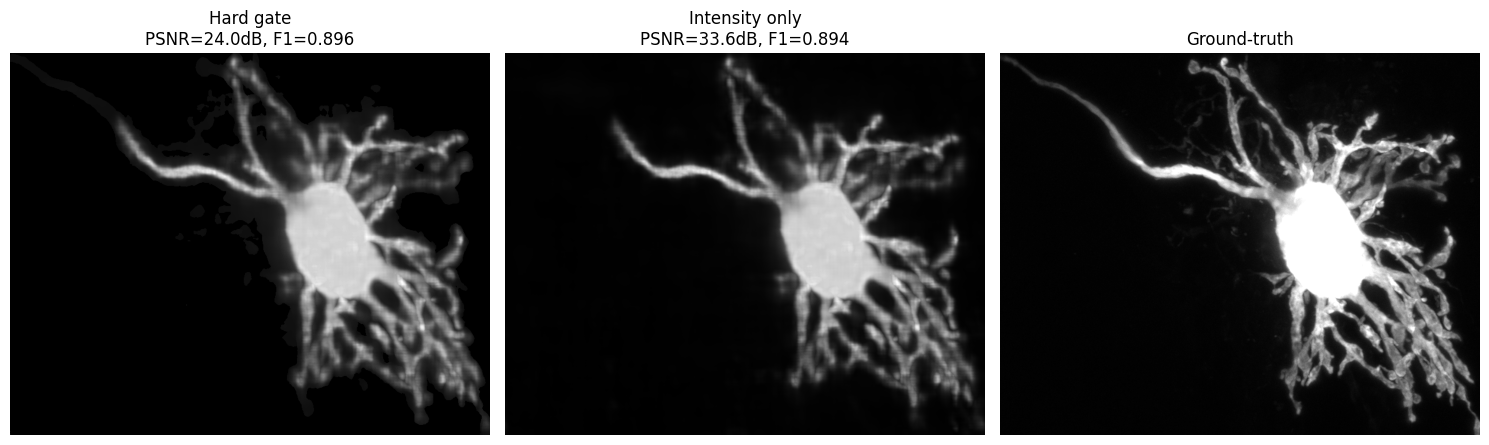

: 

In [ ]:
@torch.no_grad()
def export_volume_global(model, batch_size=100000, gate_mode='hard', tau=0.15):
    """Export volume by querying the model globally.
    
    gate_mode: 'soft' = p * intensity, 'hard' = threshold p, 'none' = intensity only
    """
    model.eval()
    H, W, D = shape
    
    V_out = np.zeros(shape, dtype=np.float32)
    
    total_voxels = H * W * D
    xs = torch.arange(H, device=device, dtype=torch.float32)
    ys = torch.arange(W, device=device, dtype=torch.float32)
    zs = torch.arange(D, device=device, dtype=torch.float32)
    all_coords = torch.stack(torch.meshgrid(xs, ys, zs, indexing='ij'), dim=-1).reshape(-1, 3)
    
    for i in range(0, total_voxels, batch_size):
        end_i = min(i + batch_size, total_voxels)
        coords = all_coords[i:end_i]
        coords01 = normalize_coords(coords, shape)
        
        # Get occupancy probability
        p = model.occ_prob(coords01)
        
        # Get brick codes for these coordinates
        bxyz = brick_index_from_x01(coords01, shape, model.brick_size)
        indices = brick_code_mgr.get_or_create_indices(bxyz, model._code_init)
        z = brick_code_mgr.codes[indices]
        
        # Get intensity
        intensity = model.intensity(coords01, z)
        
        # Apply gating
        if gate_mode == 'soft':
            v = p * intensity
        elif gate_mode == 'hard':
            mask = (p > tau).float()
            v = mask * intensity
        else:  # 'none'
            v = intensity
        
        flat_idx = (coords[:, 0].long() * W * D + 
                   coords[:, 1].long() * D + 
                   coords[:, 2].long())
        V_out.flat[flat_idx.cpu().numpy()] = v.cpu().numpy()
    
    return V_out
x
# Export volumes
print("Exporting volumes...")
V_hard = export_volume_global(model, batch_size=100000, gate_mode='hard', tau=0.10)
V_intensity = export_volume_global(model, batch_size=100000, gate_mode='none')

# ============================================================================
# COMPREHENSIVE METRICS
# ============================================================================
from math import log10
from scipy import ndimage
from skimage.morphology import skeletonize_3d
from skimage.measure import label as label_connected_components

print("\n" + "="*70)
print("EVALUATION METRICS")
print("="*70)

# ---------------------------------------------------------------------------
# 1. FIDELITY METRICS (Volume-wise)
# ---------------------------------------------------------------------------
def compute_psnr(pred, gt, max_val=1.0):
    """Peak Signal-to-Noise Ratio."""
    mse = np.mean((pred - gt) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * log10(max_val**2 / mse)

def compute_ssim_3d(pred, gt, win_size=7):
    """Structural Similarity Index (3D volume)."""
    # Constants for stability
    C1 = (0.01) ** 2
    C2 = (0.03) ** 2
    
    # Use uniform filter for local statistics
    kernel_size = win_size
    
    mu_pred = ndimage.uniform_filter(pred, size=kernel_size)
    mu_gt = ndimage.uniform_filter(gt, size=kernel_size)
    
    mu_pred_sq = mu_pred ** 2
    mu_gt_sq = mu_gt ** 2
    mu_pred_gt = mu_pred * mu_gt
    
    sigma_pred_sq = ndimage.uniform_filter(pred ** 2, size=kernel_size) - mu_pred_sq
    sigma_gt_sq = ndimage.uniform_filter(gt ** 2, size=kernel_size) - mu_gt_sq
    sigma_pred_gt = ndimage.uniform_filter(pred * gt, size=kernel_size) - mu_pred_gt
    
    ssim_map = ((2 * mu_pred_gt + C1) * (2 * sigma_pred_gt + C2)) / \
               ((mu_pred_sq + mu_gt_sq + C1) * (sigma_pred_sq + sigma_gt_sq + C2))
    
    return float(np.mean(ssim_map))

print("\n[1] FIDELITY METRICS (Volume-wise)")
print("-" * 40)

psnr_hard = compute_psnr(V_hard, V_np)
psnr_intensity = compute_psnr(V_intensity, V_np)
ssim_hard = compute_ssim_3d(V_hard, V_np)
ssim_intensity = compute_ssim_3d(V_intensity, V_np)

print(f"  Hard gate:      PSNR = {psnr_hard:.2f} dB,  SSIM = {ssim_hard:.4f}")
print(f"  Intensity only: PSNR = {psnr_intensity:.2f} dB,  SSIM = {ssim_intensity:.4f}")

# MIP metrics
psnr_hard_mip = compute_psnr(mip_xy(V_hard), mip_xy(V_np))
psnr_intensity_mip = compute_psnr(mip_xy(V_intensity), mip_xy(V_np))
print(f"\n  MIP PSNR (Hard gate):      {psnr_hard_mip:.2f} dB")
print(f"  MIP PSNR (Intensity only): {psnr_intensity_mip:.2f} dB")

# ---------------------------------------------------------------------------
# 2. STRUCTURE/TOPOLOGY METRICS
# ---------------------------------------------------------------------------
print("\n[2] STRUCTURE/TOPOLOGY METRICS")
print("-" * 40)

# Binarize volumes for structural analysis
thresh = 0.15
mask_gt = (V_np > thresh).astype(np.uint8)
mask_hard = (V_hard > thresh).astype(np.uint8)
mask_intensity = (V_intensity > thresh).astype(np.uint8)

# 2a. Connected Components Count
def count_connected_components(mask, min_size=10):
    """Count connected components, filtering small noise."""
    labeled, num_features = label_connected_components(mask, return_num=True)
    # Filter small components
    component_sizes = np.bincount(labeled.ravel())
    large_components = np.sum(component_sizes[1:] >= min_size)  # exclude background (0)
    return num_features, large_components

cc_gt_all, cc_gt_large = count_connected_components(mask_gt)
cc_hard_all, cc_hard_large = count_connected_components(mask_hard)
cc_int_all, cc_int_large = count_connected_components(mask_intensity)

print(f"\n  2a. Connected Components (min_size=10 voxels)")
print(f"      Ground truth:   {cc_gt_large:4d} (total: {cc_gt_all})")
print(f"      Hard gate:      {cc_hard_large:4d} (total: {cc_hard_all})")
print(f"      Intensity only: {cc_int_large:4d} (total: {cc_int_all})")

# 2b. Thin-Structure Recall / F1 Score
def compute_structure_f1(pred_mask, gt_mask):
    """Compute precision, recall, F1 for foreground voxels."""
    tp = np.sum(pred_mask & gt_mask)
    fp = np.sum(pred_mask & ~gt_mask)
    fn = np.sum(~pred_mask & gt_mask)
    
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    
    return precision, recall, f1

prec_hard, rec_hard, f1_hard = compute_structure_f1(mask_hard, mask_gt)
prec_int, rec_int, f1_int = compute_structure_f1(mask_intensity, mask_gt)

print(f"\n  2b. Thin-Structure Recall (Foreground F1)")
print(f"      Hard gate:      Prec={prec_hard:.3f}, Recall={rec_hard:.3f}, F1={f1_hard:.3f}")
print(f"      Intensity only: Prec={prec_int:.3f}, Recall={rec_int:.3f}, F1={f1_int:.3f}")

# 2c. Skeleton Continuity / Branch Break Rate
def compute_skeleton_metrics(pred_mask, gt_mask):
    """Compute skeleton-based continuity metrics."""
    # Skeletonize both
    skel_gt = skeletonize_3d(gt_mask)
    skel_pred = skeletonize_3d(pred_mask)
    
    # Skeleton voxel counts
    n_skel_gt = np.sum(skel_gt > 0)
    n_skel_pred = np.sum(skel_pred > 0)
    
    # How much of GT skeleton is covered by pred mask?
    gt_skel_covered = np.sum((skel_gt > 0) & (pred_mask > 0))
    skeleton_recall = gt_skel_covered / (n_skel_gt + 1e-8)
    
    # How much of pred skeleton matches GT mask?
    pred_skel_in_gt = np.sum((skel_pred > 0) & (gt_mask > 0))
    skeleton_precision = pred_skel_in_gt / (n_skel_pred + 1e-8)
    
    # Connected components in skeletons (fewer = more continuous)
    _, n_cc_gt_skel = label_connected_components(skel_gt, return_num=True)
    _, n_cc_pred_skel = label_connected_components(skel_pred, return_num=True)
    
    # Branch break rate: extra components relative to GT
    branch_break_rate = max(0, n_cc_pred_skel - n_cc_gt_skel) / (n_cc_gt_skel + 1e-8)
    
    return {
        'skel_precision': skeleton_precision,
        'skel_recall': skeleton_recall,
        'n_skel_gt': n_skel_gt,
        'n_skel_pred': n_skel_pred,
        'n_cc_gt_skel': n_cc_gt_skel,
        'n_cc_pred_skel': n_cc_pred_skel,
        'branch_break_rate': branch_break_rate
    }

print(f"\n  2c. Skeleton Continuity & Branch Break Rate")
skel_hard = compute_skeleton_metrics(mask_hard, mask_gt)
skel_int = compute_skeleton_metrics(mask_intensity, mask_gt)

print(f"      Ground truth skeleton: {skel_hard['n_skel_gt']} voxels, {skel_hard['n_cc_gt_skel']} components")
print(f"      Hard gate:")
print(f"        - Skeleton voxels: {skel_hard['n_skel_pred']}, components: {skel_hard['n_cc_pred_skel']}")
print(f"        - Skeleton Precision: {skel_hard['skel_precision']:.3f}, Recall: {skel_hard['skel_recall']:.3f}")
print(f"        - Branch Break Rate: {skel_hard['branch_break_rate']:.3f}")
print(f"      Intensity only:")
print(f"        - Skeleton voxels: {skel_int['n_skel_pred']}, components: {skel_int['n_cc_pred_skel']}")
print(f"        - Skeleton Precision: {skel_int['skel_precision']:.3f}, Recall: {skel_int['skel_recall']:.3f}")
print(f"        - Branch Break Rate: {skel_int['branch_break_rate']:.3f}")

# 2d. Longest Path Preservation
def compute_longest_path_ratio(pred_mask, gt_mask):
    """Estimate longest path preservation using skeleton length."""
    skel_gt = skeletonize_3d(gt_mask)
    skel_pred = skeletonize_3d(pred_mask)
    
    # Find largest connected component in each skeleton
    labeled_gt, n_gt = label_connected_components(skel_gt, return_num=True)
    labeled_pred, n_pred = label_connected_components(skel_pred, return_num=True)
    
    if n_gt == 0 or n_pred == 0:
        return 0.0, 0, 0
    
    # Size of largest component (proxy for longest continuous structure)
    sizes_gt = np.bincount(labeled_gt.ravel())
    sizes_pred = np.bincount(labeled_pred.ravel())
    
    max_gt = np.max(sizes_gt[1:]) if len(sizes_gt) > 1 else 0
    max_pred = np.max(sizes_pred[1:]) if len(sizes_pred) > 1 else 0
    
    ratio = max_pred / (max_gt + 1e-8)
    return ratio, max_gt, max_pred

lp_ratio_hard, lp_gt, lp_hard = compute_longest_path_ratio(mask_hard, mask_gt)
lp_ratio_int, _, lp_int = compute_longest_path_ratio(mask_intensity, mask_gt)

print(f"\n  2d. Longest Path Preservation (largest skeleton component)")
print(f"      Ground truth longest: {lp_gt} voxels")
print(f"      Hard gate:      {lp_hard} voxels (ratio: {lp_ratio_hard:.3f})")
print(f"      Intensity only: {lp_int} voxels (ratio: {lp_ratio_int:.3f})")

# ---------------------------------------------------------------------------
# SUMMARY TABLE
# ---------------------------------------------------------------------------
print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(f"{'Metric':<30} {'Hard Gate':<15} {'Intensity Only':<15}")
print("-"*60)
print(f"{'PSNR (volume) [dB]':<30} {psnr_hard:<15.2f} {psnr_intensity:<15.2f}")
print(f"{'SSIM (volume)':<30} {ssim_hard:<15.4f} {ssim_intensity:<15.4f}")
print(f"{'PSNR (MIP) [dB]':<30} {psnr_hard_mip:<15.2f} {psnr_intensity_mip:<15.2f}")
print(f"{'Foreground F1':<30} {f1_hard:<15.3f} {f1_int:<15.3f}")
print(f"{'Connected Components':<30} {cc_hard_large:<15d} {cc_int_large:<15d}")
print(f"{'Skeleton Recall':<30} {skel_hard['skel_recall']:<15.3f} {skel_int['skel_recall']:<15.3f}")
print(f"{'Branch Break Rate':<30} {skel_hard['branch_break_rate']:<15.3f} {skel_int['branch_break_rate']:<15.3f}")
print(f"{'Longest Path Ratio':<30} {lp_ratio_hard:<15.3f} {lp_ratio_int:<15.3f}")
print("="*70)

# ---------------------------------------------------------------------------
# VISUALIZATION
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(mip_xy(V_hard), cmap="gray")
axes[0].set_title(f"Hard gate\nPSNR={psnr_hard:.1f}dB, F1={f1_hard:.3f}")
axes[0].axis("off")

axes[1].imshow(mip_xy(V_intensity), cmap="gray")
axes[1].set_title(f"Intensity only\nPSNR={psnr_intensity:.1f}dB, F1={f1_int:.3f}")
axes[1].axis("off")

axes[2].imshow(mip_xy(V_np), cmap="gray")
axes[2].set_title("Ground-truth")
axes[2].axis("off")

plt.tight_layout()
plt.show()

## 8. Notes for adapting to your microscopy dataset
1) Replace `make_toy_volume()` with a loader that returns a dense grid `V` (float32, normalized) and optionally a weak mask `M0`.
2) For real microscopy, handle anisotropic voxel spacing (\(\Delta z \gg \Delta x, \Delta y\)):
   - scale coordinates before positional encoding
   - use anisotropic kNN weights in `topology_laplacian_loss`
3) If you have SWC skeletons, add a skeleton tube loss (strongest topology prior).
4) If you reconstruct from measurements (views/projections), replace `loss_data` with a differentiable forward model \(\Pi\) and sample rays only through occupied bricks.
5) For speed in production:
   - store brick codes in a GPU hash table or fixed tensor for active bricks
   - batch bricks and query only active bricks


In [12]:
!pip install scipy

In [13]:
## 9. Gaussian Volume Reconstruction with Hard Gate Guidance

Use the trained TOPS-Gate hard gate to:
1. **Identify occupied regions** where Gaussians should be placed
2. **Initialize Gaussians only in occupied space** - no wasted parameters in empty regions
3. **Sample training points only from occupied regions** - avoid computing empty space
4. **Adaptive densification** - add Gaussians where needed based on reconstruction error

SyntaxError: invalid syntax (1007398239.py, line 3)

In [ ]:
import sys
sys.path.insert(0, '/mnt/intelpa-1/armin/containers/storage/Method2')

# ============================================================================
# GAUSSIAN VOLUME MODEL WITH HARD GATE GUIDANCE
# ============================================================================

class GaussianBasis3D(nn.Module):
    """
    3D Gaussian basis functions for volume reconstruction.
    
    Each Gaussian: G_i(x) = w_i * exp(-0.5 * (x - μ_i)^T Σ_i^-1 (x - μ_i))
    
    Uses log-scale and quaternion parameterization for stable optimization.
    """
    
    def __init__(self, num_gaussians: int, device='cuda'):
        super().__init__()
        self.num_gaussians = num_gaussians
        self.device = device
        
        # Learnable parameters (will be initialized from gate)
        self.positions = nn.Parameter(torch.zeros(num_gaussians, 3, device=device))
        self.log_scales = nn.Parameter(torch.zeros(num_gaussians, 3, device=device))
        self.rotations = nn.Parameter(torch.zeros(num_gaussians, 4, device=device))  # quaternion
        self.weights = nn.Parameter(torch.zeros(num_gaussians, device=device))
        
    def _quaternion_to_rotation(self, q):
        """Convert quaternions (N, 4) to rotation matrices (N, 3, 3)."""
        q = q / (q.norm(dim=1, keepdim=True) + 1e-8)
        w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
        
        R = torch.zeros(q.shape[0], 3, 3, device=q.device)
        R[:, 0, 0] = 1 - 2*(y**2 + z**2)
        R[:, 0, 1] = 2*(x*y - z*w)
        R[:, 0, 2] = 2*(x*z + y*w)
        R[:, 1, 0] = 2*(x*y + z*w)
        R[:, 1, 1] = 1 - 2*(x**2 + z**2)
        R[:, 1, 2] = 2*(y*z - x*w)
        R[:, 2, 0] = 2*(x*z - y*w)
        R[:, 2, 1] = 2*(y*z + x*w)
        R[:, 2, 2] = 1 - 2*(x**2 + y**2)
        return R
    
    def get_covariances(self):
        """Compute covariance matrices: Σ = R * diag(s²) * R^T"""
        scales = torch.exp(self.log_scales)  # (N, 3)
        R = self._quaternion_to_rotation(self.rotations)  # (N, 3, 3)
        S = torch.diag_embed(scales ** 2)  # (N, 3, 3)
        return torch.bmm(torch.bmm(R, S), R.transpose(1, 2))
    
    def forward(self, points: torch.Tensor) -> torch.Tensor:
        """
        Evaluate f(x) = Σ w_i * G_i(x) at query points.
        
        Args:
            points: (M, 3) query coordinates (in voxel space)
            
        Returns:
            values: (M,) reconstructed intensities
        """
        M = points.shape[0]
        N = self.num_gaussians
        
        # Get covariance matrices and their inverses
        cov = self.get_covariances()  # (N, 3, 3)
        cov_inv = torch.linalg.inv(cov + 1e-6 * torch.eye(3, device=self.device))
        
        # Compute (x - μ) for all points and all Gaussians
        diff = points.unsqueeze(1) - self.positions.unsqueeze(0)  # (M, N, 3)
        
        # Quadratic form: (x-μ)^T Σ^-1 (x-μ)
        quad = torch.einsum('mni,nij,mnj->mn', diff, cov_inv, diff)  # (M, N)
        
        # Gaussian values with weights
        gauss_vals = torch.exp(-0.5 * quad)  # (M, N)
        
        # Weighted sum
        output = torch.matmul(gauss_vals, F.softplus(self.weights))  # (M,)
        
        return output
    
    def initialize_from_gate(self, model: TOPSGate, tau: float, shape: tuple, 
                            num_samples: int = 50000, percentile: float = 0.99):
        """
        Initialize Gaussians from TOPS-Gate occupied regions.
        
        Args:
            model: Trained TOPSGate model
            tau: Gate threshold
            shape: Volume shape (H, W, D)
            num_samples: Number of samples for finding occupied regions
            percentile: Use top percentile of occupancy probability
        """
        model.eval()
        H, W, D = shape
        
        with torch.no_grad():
            # Sample points uniformly
            x01 = torch.rand(num_samples, 3, device=self.device)
            
            # Get occupancy probabilities
            p = model.occ_prob(x01)
            
            # Find points above threshold (occupied regions)
            occupied_mask = p > tau
            occupied_points = x01[occupied_mask]
            occupied_probs = p[occupied_mask]
            
            print(f"Found {occupied_points.shape[0]} occupied points from {num_samples} samples")
            
            if occupied_points.shape[0] < self.num_gaussians:
                # If not enough occupied points, use top-k by probability
                topk_idx = torch.topk(p, self.num_gaussians).indices
                occupied_points = x01[topk_idx]
                occupied_probs = p[topk_idx]
            
            # Select Gaussian centers using k-means-like clustering
            # Simple version: random subsample from occupied
            perm = torch.randperm(occupied_points.shape[0], device=self.device)[:self.num_gaussians]
            centers_01 = occupied_points[perm]
            
            # Convert from [0,1] to voxel coordinates
            centers_voxel = centers_01.clone()
            centers_voxel[:, 0] *= (H - 1)
            centers_voxel[:, 1] *= (W - 1)
            centers_voxel[:, 2] *= (D - 1)
            
            # Initialize positions
            self.positions.data = centers_voxel
            
            # Initialize scales based on local density
            # Larger scale in sparse regions, smaller in dense
            avg_spacing = ((H * W * D) / self.num_gaussians) ** (1/3)
            initial_scale = avg_spacing * 0.3
            self.log_scales.data.fill_(np.log(initial_scale))
            
            # Initialize rotations to identity (w=1, x=y=z=0)
            self.rotations.data.zero_()
            self.rotations.data[:, 0] = 1.0
            
            # Initialize weights based on local intensity
            gt_intensities = trilinear_sample_volume(V, centers_01)
            self.weights.data = torch.log(gt_intensities.clamp(min=0.01) + 1)  # inverse softplus approx
            
        print(f"Initialized {self.num_gaussians} Gaussians in occupied regions")
        print(f"  Position range: [{self.positions.min():.1f}, {self.positions.max():.1f}]")
        print(f"  Scale range: [{torch.exp(self.log_scales).min():.2f}, {torch.exp(self.log_scales).max():.2f}]")


class GateGuidedGaussianTrainer:
    """
    Train Gaussian volume with TOPS-Gate guidance for compute efficiency.
    
    Key savings:
    1. Initialize Gaussians only in occupied regions
    2. Sample training points only from occupied regions
    3. Skip computing Gaussian contributions in empty space
    """
    
    def __init__(
        self,
        gaussian_model: GaussianBasis3D,
        gate_model: TOPSGate,
        volume: torch.Tensor,
        shape: tuple,
        tau_gate: float = 0.15,
        device: str = 'cuda'
    ):
        self.gaussians = gaussian_model.to(device)
        self.gate_model = gate_model.to(device)
        self.V = volume.to(device)
        self.shape = shape
        self.tau_gate = tau_gate
        self.device = device
        
        # Cache occupied mask for fast sampling
        self._precompute_occupied_voxels()
        
    def _precompute_occupied_voxels(self, batch_size: int = 100000):
        """Precompute occupied voxel locations using gate."""
        self.gate_model.eval()
        H, W, D = self.shape
        
        # Evaluate gate on a coarse grid first
        with torch.no_grad():
            # Full grid evaluation for small volumes
            xs = torch.arange(H, device=self.device, dtype=torch.float32)
            ys = torch.arange(W, device=self.device, dtype=torch.float32)
            zs = torch.arange(D, device=self.device, dtype=torch.float32)
            
            all_coords = torch.stack(torch.meshgrid(xs, ys, zs, indexing='ij'), dim=-1).reshape(-1, 3)
            all_coords_01 = normalize_coords(all_coords, self.shape)
            
            # Batch evaluation
            occupied_list = []
            for i in range(0, all_coords_01.shape[0], batch_size):
                batch = all_coords_01[i:i+batch_size]
                p = self.gate_model.occ_prob(batch)
                occ = (p > self.tau_gate)
                occupied_list.append(occ)
            
            occupied_mask = torch.cat(occupied_list)
            self.occupied_coords = all_coords[occupied_mask]  # Voxel coordinates
            self.occupied_coords_01 = all_coords_01[occupied_mask]  # Normalized
            self.occupied_gt = self.V.flatten()[occupied_mask]
            
        print(f"Precomputed {self.occupied_coords.shape[0]} occupied voxels "
              f"({100*self.occupied_coords.shape[0]/(H*W*D):.1f}% of volume)")
    
    def sample_occupied_batch(self, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Sample training points from occupied regions only."""
        n_occupied = self.occupied_coords.shape[0]
        indices = torch.randint(0, n_occupied, (batch_size,), device=self.device)
        
        coords = self.occupied_coords[indices]  # Voxel space
        coords_01 = self.occupied_coords_01[indices]  # Normalized [0,1]
        gt_values = self.occupied_gt[indices]
        
        return coords, coords_01, gt_values
    
    def train_step(self, coords: torch.Tensor, gt_values: torch.Tensor, opt: torch.optim.Optimizer):
        """Single training step."""
        opt.zero_grad()
        
        # Forward pass through Gaussians
        pred = self.gaussians(coords)
        
        # MSE loss
        loss = F.mse_loss(pred, gt_values)
        
        # Regularization: encourage compact Gaussians
        scales = torch.exp(self.gaussians.log_scales)
        scale_reg = 0.001 * (scales ** 2).mean()
        
        # Weight sparsity
        weight_reg = 0.0001 * F.softplus(self.gaussians.weights).abs().mean()
        
        total_loss = loss + scale_reg + weight_reg
        
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.gaussians.parameters(), max_norm=1.0)
        opt.step()
        
        return loss.item(), total_loss.item()
    
    def reconstruct_volume(self, batch_size: int = 100000) -> np.ndarray:
        """Reconstruct full volume from Gaussians."""
        self.gaussians.eval()
        H, W, D = self.shape
        
        V_out = np.zeros(self.shape, dtype=np.float32)
        
        with torch.no_grad():
            xs = torch.arange(H, device=self.device, dtype=torch.float32)
            ys = torch.arange(W, device=self.device, dtype=torch.float32)
            zs = torch.arange(D, device=self.device, dtype=torch.float32)
            
            all_coords = torch.stack(torch.meshgrid(xs, ys, zs, indexing='ij'), dim=-1).reshape(-1, 3)
            
            for i in range(0, all_coords.shape[0], batch_size):
                batch = all_coords[i:i+batch_size]
                pred = self.gaussians(batch)
                
                flat_idx = (batch[:, 0].long() * W * D + 
                           batch[:, 1].long() * D + 
                           batch[:, 2].long())
                V_out.flat[flat_idx.cpu().numpy()] = pred.cpu().numpy()
        
        return V_out
    
    def reconstruct_with_gate(self, batch_size: int = 100000) -> np.ndarray:
        """Reconstruct volume, but only compute where gate says occupied."""
        self.gaussians.eval()
        self.gate_model.eval()
        H, W, D = self.shape
        
        V_out = np.zeros(self.shape, dtype=np.float32)
        
        with torch.no_grad():
            # Only compute at occupied voxels
            for i in range(0, self.occupied_coords.shape[0], batch_size):
                coords = self.occupied_coords[i:i+batch_size]
                pred = self.gaussians(coords)
                
                flat_idx = (coords[:, 0].long() * W * D + 
                           coords[:, 1].long() * D + 
                           coords[:, 2].long())
                V_out.flat[flat_idx.cpu().numpy()] = pred.cpu().numpy()
        
        return V_out


print("Gaussian Volume classes defined!")
print(f"Using trained TOPS-Gate with tau={0.15} to guide Gaussian placement")

Gaussian Volume classes defined!
Using trained TOPS-Gate with tau=0.15 to guide Gaussian placement


In [ ]:
# ============================================================================
# INITIALIZE AND TRAIN GAUSSIANS USING HARD GATE
# ============================================================================

# Configuration
NUM_GAUSSIANS = 5000  # Number of Gaussian basis functions
GATE_TAU = 0.15       # Hard gate threshold
TRAIN_STEPS = 10000   # Training iterations
BATCH_SIZE = 32768    # Points per batch
LOG_EVERY = 500

print("="*70)
print("GAUSSIAN VOLUME RECONSTRUCTION WITH HARD GATE GUIDANCE")
print("="*70)
print(f"Configuration:")
print(f"  Number of Gaussians: {NUM_GAUSSIANS}")
print(f"  Gate threshold (tau): {GATE_TAU}")
print(f"  Training steps: {TRAIN_STEPS}")
print(f"  Batch size: {BATCH_SIZE}")
print()

# Create Gaussian model
gaussian_model = GaussianBasis3D(num_gaussians=NUM_GAUSSIANS, device=device)

# Initialize Gaussians from TOPS-Gate occupied regions
print("Initializing Gaussians from TOPS-Gate occupied regions...")
gaussian_model.initialize_from_gate(model, tau=GATE_TAU, shape=shape, num_samples=100000)

# Create trainer with gate guidance
trainer = GateGuidedGaussianTrainer(
    gaussian_model=gaussian_model,
    gate_model=model,
    volume=V,
    shape=shape,
    tau_gate=GATE_TAU,
    device=device
)

# Optimizer with different learning rates
opt_gaussian = torch.optim.Adam([
    {'params': [gaussian_model.positions], 'lr': 1e-2},      # Positions - learn fast
    {'params': [gaussian_model.log_scales], 'lr': 5e-3},     # Scales
    {'params': [gaussian_model.rotations], 'lr': 1e-3},      # Rotations - stable
    {'params': [gaussian_model.weights], 'lr': 2e-2}         # Weights - learn fast
])

scheduler_gaussian = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt_gaussian, T_max=TRAIN_STEPS, eta_min=1e-5
)

# Training loop
print("\nStarting Gaussian training (using only occupied regions)...")
print("-" * 70)

gaussian_losses = []

for step in range(1, TRAIN_STEPS + 1):
    gaussian_model.train()
    
    # Sample from occupied regions only (compute savings!)
    coords, coords_01, gt_values = trainer.sample_occupied_batch(BATCH_SIZE)
    
    # Training step
    mse_loss, total_loss = trainer.train_step(coords, gt_values, opt_gaussian)
    scheduler_gaussian.step()
    
    gaussian_losses.append(mse_loss)
    
    if step % LOG_EVERY == 0 or step == 1:
        # Quick validation
        with torch.no_grad():
            val_coords, _, val_gt = trainer.sample_occupied_batch(10000)
            val_pred = gaussian_model(val_coords)
            val_mse = F.mse_loss(val_pred, val_gt).item()
            
            # Compute rough PSNR
            psnr_approx = 10 * np.log10(1.0 / (val_mse + 1e-10))
        
        current_lr = scheduler_gaussian.get_last_lr()[0]
        scales = torch.exp(gaussian_model.log_scales)
        
        print(f"Step {step:5d} | lr={current_lr:.2e} | train_mse={mse_loss:.5f} | "
              f"val_mse={val_mse:.5f} | PSNR~{psnr_approx:.1f}dB | "
              f"scale=[{scales.min().item():.2f}, {scales.max().item():.2f}]")

print("-" * 70)
print("Gaussian training complete!")
print(f"Final training MSE: {gaussian_losses[-1]:.5f}")

GAUSSIAN VOLUME RECONSTRUCTION WITH HARD GATE GUIDANCE
Configuration:
  Number of Gaussians: 5000
  Gate threshold (tau): 0.15
  Training steps: 10000
  Batch size: 32768

Initializing Gaussians from TOPS-Gate occupied regions...
Found 3539 occupied points from 100000 samples
Initialized 5000 Gaussians in occupied regions
  Position range: [0.1, 254.9]
  Scale range: [3.56, 3.56]
Precomputed 297334 occupied voxels (3.5% of volume)

Starting Gaussian training (using only occupied regions)...
----------------------------------------------------------------------
Step     1 | lr=1.00e-02 | train_mse=17.79177 | val_mse=16.51219 | PSNR~-12.2dB | scale=[3.55, 3.55]


KeyboardInterrupt: 

In [ ]:
## 10. Save Ground Truth and Train with Dec24_GaussianVolume

Save the ground truth volume as .tif and use the `Dec24_GaussianVolume/train_cuda.py` script to reconstruct 3D Gaussians with hard gate guidance.

In [ ]:
# ============================================================================
# STEP 1: SAVE GROUND TRUTH VOLUME AS TIFF
# ============================================================================
import tifffile as tiff
import os

# Create output directory
output_dir = "output/gaussian_with_gate"
os.makedirs(output_dir, exist_ok=True)

# Save ground truth volume as TIFF
gt_path = os.path.join(output_dir, "ground_truth.tif")
tiff.imwrite(gt_path, V_np.astype(np.float32))
print(f"✓ Saved ground truth volume: {gt_path}")
print(f"  Shape: {V_np.shape}")
print(f"  Value range: [{V_np.min():.3f}, {V_np.max():.3f}]")

# Also save the occupancy mask from hard gate
gate_mask_path = os.path.join(output_dir, "hard_gate_mask.tif")
tiff.imwrite(gate_mask_path, (V_hard > 0.1).astype(np.uint8) * 255)
print(f"✓ Saved hard gate mask: {gate_mask_path}")

✓ Saved ground truth volume: output/gaussian_with_gate/ground_truth.tif
  Shape: (256, 256, 128)
  Value range: [0.000, 1.000]
✓ Saved hard gate mask: output/gaussian_with_gate/hard_gate_mask.tif


In [ ]:
# ============================================================================
# STEP 2: SAVE TOPS-GATE MODEL CHECKPOINT
# ============================================================================

# Save the trained TOPS-Gate model for later use
gate_checkpoint_path = os.path.join(output_dir, "tops_gate_checkpoint.pt")

gate_checkpoint = {
    'model_state_dict': model.state_dict(),
    'brick_codes': brick_code_mgr.codes.data.cpu(),
    'brick_key_to_idx': brick_code_mgr.key_to_idx,
    'brick_size': model.brick_size,
    'code_dim': model.code_dim,
    'pe_L': model.pe_L,
    'volume_shape': shape,
    'tau_gate': 0.15,  # Gate threshold used
}

torch.save(gate_checkpoint, gate_checkpoint_path)
print(f"✓ Saved TOPS-Gate checkpoint: {gate_checkpoint_path}")
print(f"  Model params: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Brick codes: {len(brick_code_mgr)} bricks")

In [ ]:
# ============================================================================
# STEP 3: LOAD HARD GATE MODEL AND GENERATE OCCUPIED POSITIONS
# ============================================================================

# Load the trained TOPS-Gate model from checkpoint
gate_checkpoint_path = "output/checkpoints/tops_gate_step_020000.pt"
print(f"Loading hard gate model from: {gate_checkpoint_path}")

checkpoint = torch.load(gate_checkpoint_path, map_location=device)

# Recreate the model architecture
gate_model = TOPSGate(brick_size=16, code_dim=32, pe_L=8).to(device)
gate_model.load_state_dict(checkpoint['model_state_dict'])
gate_model.eval()

# Load brick codes
gate_brick_codes = checkpoint['brick_codes'].to(device)
gate_brick_key_to_idx = checkpoint['brick_key_to_idx']

print(f"✓ Loaded TOPS-Gate model")
print(f"  Step: {checkpoint['step']}")
print(f"  Brick codes: {len(gate_brick_key_to_idx)} bricks")

# Generate occupied coordinates from hard gate for initializing Gaussians
@torch.no_grad()
def export_occupied_positions(gate_model, tau, volume_shape, num_samples=100000, device='cuda'):
    """Export occupied voxel positions from hard gate for Gaussian initialization."""
    gate_model.eval()
    H, W, D = volume_shape
    
    # Sample uniformly and filter by gate
    x01 = torch.rand(num_samples, 3, device=device)
    p = gate_model.occ_prob(x01)
    
    # Get occupied positions
    occupied_mask = p > tau
    occupied_x01 = x01[occupied_mask]
    occupied_probs = p[occupied_mask]
    
    # Convert to voxel coordinates
    occupied_voxel = occupied_x01.clone()
    occupied_voxel[:, 0] *= (H - 1)
    occupied_voxel[:, 1] *= (W - 1)
    occupied_voxel[:, 2] *= (D - 1)
    
    return occupied_voxel.cpu().numpy(), occupied_probs.cpu().numpy()

# Export occupied positions using loaded gate model
GATE_TAU = 0.15
occupied_coords, occupied_probs = export_occupied_positions(
    gate_model, tau=GATE_TAU, volume_shape=shape, num_samples=200000, device=device
)

print(f"\nOccupied positions for Gaussian initialization:")
print(f"  Total sampled: 200,000")
print(f"  Occupied (gate > {GATE_TAU}): {len(occupied_coords)}")
print(f"  Occupancy rate: {100*len(occupied_coords)/200000:.1f}%")

# Save occupied positions as NPY for external use
occupied_path = os.path.join(output_dir, "occupied_positions.npy")
np.save(occupied_path, occupied_coords)
print(f"✓ Saved occupied positions: {occupied_path}")

Loading hard gate model from: output/checkpoints/tops_gate_step_020000.pt
✓ Loaded TOPS-Gate model
  Step: 20000
  Brick codes: 2048 bricks

Occupied positions for Gaussian initialization:
  Total sampled: 200,000
  Occupied (gate > 0.15): 7303
  Occupancy rate: 3.7%
✓ Saved occupied positions: output/gaussian_with_gate/occupied_positions.npy


In [ ]:
# ============================================================================
# STEP 4: LOAD Dec24_GaussianVolume AND TRAIN WITH GATE GUIDANCE
# ============================================================================

import sys
sys.path.insert(0, '/mnt/intelpa-1/armin/containers/storage/Method2/Dec24_GaussianVolume')

# Use the non-CUDA version (pure PyTorch) - avoids gs_utils dependency
from gaussian_model_cuda import GaussianVolumeModel
from train_cuda import GaussianVolumeTrainer

# Load ground truth volume
volume_tensor = torch.from_numpy(V_np).float()

print("="*70)
print("Dec24_GaussianVolume with Hard Gate Guidance")
print("="*70)
print(f"Using hard gate model: output/checkpoints/tops_gate_step_020000.pt")

# Configuration
NUM_GAUSSIANS_INIT = 8000  # Initial number of Gaussians (placed in occupied regions)
EPOCHS = 200
LEARNING_RATE = 0.01

# Initialize model with gate-guided positions
print("\nInitializing Gaussians from hard gate occupied regions...")

# Create model
gaussian_vol_model = GaussianVolumeModel(
    num_gaussians=NUM_GAUSSIANS_INIT,
    volume_shape=shape,
    init_method='uniform',  # We'll override positions
    device='cuda'
)

# Override positions with gate-guided initialization
with torch.no_grad():
    # Use occupied positions from gate
    n_init = min(NUM_GAUSSIANS_INIT, len(occupied_coords))
    perm = np.random.permutation(len(occupied_coords))[:n_init]
    init_positions = occupied_coords[perm]
    
    # Set positions directly (in voxel coordinates)
    gaussian_vol_model.gaussians.positions.data = torch.tensor(
        init_positions, dtype=torch.float32, device='cuda'
    )

print(f"  Initialized {n_init} Gaussians in gate-occupied regions")
print(f"  Parameters: {sum(p.numel() for p in gaussian_vol_model.parameters()):,}")

# Create trainer
gaussian_trainer = GaussianVolumeTrainer(
    model=gaussian_vol_model,
    volume=volume_tensor,
    learning_rate=LEARNING_RATE,
    optimizer_type='adam',
    lambda_sparsity=0.001,
    lambda_overlap=0.001,
    lambda_smoothness=0.001,
    use_sparsity=True,
    use_overlap=True,
    use_smoothness=True,
    device='cuda'
)

print(f"\nTraining configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Regularization: sparsity=0.001, overlap=0.001, smoothness=0.001")

# Train
print("\nStarting training...")
history = gaussian_trainer.train(
    num_epochs=EPOCHS,
    batch_size=8192,
    eval_interval=10,
    save_interval=50,
    save_dir=os.path.join(output_dir, 'gaussian_checkpoints'),
    verbose=True
)

print("\n" + "="*70)
print("Training Complete!")
print("="*70)
if history['psnr']:
    print(f"Final PSNR: {history['psnr'][-1]:.2f} dB")
print(f"Final Loss: {history['total_loss'][-1]:.6f}")

ImportError: attempted relative import with no known parent package

In [ ]:
# ============================================================================
# STEP 5: EVALUATE AND COMPARE RESULTS
# ============================================================================

print("="*70)
print("EVALUATION: Dec24_GaussianVolume Results")
print("="*70)

# Reconstruct volume from trained Gaussians
with torch.no_grad():
    V_cuda_gaussian = cuda_model().cpu().numpy()
    # Unnormalize if needed
    if cuda_trainer.volume_max > 0:
        V_cuda_gaussian = V_cuda_gaussian * cuda_trainer.volume_max

print(f"Reconstructed volume shape: {V_cuda_gaussian.shape}")
print(f"Value range: [{V_cuda_gaussian.min():.3f}, {V_cuda_gaussian.max():.3f}]")

# Compute metrics
psnr_cuda = compute_psnr(V_cuda_gaussian, V_np)
ssim_cuda = compute_ssim_3d(V_cuda_gaussian, V_np)
psnr_cuda_mip = compute_psnr(mip_xy(V_cuda_gaussian), mip_xy(V_np))

# Structure metrics
mask_cuda = (V_cuda_gaussian > thresh).astype(np.uint8)
cc_cuda_all, cc_cuda_large = count_connected_components(mask_cuda)
prec_cuda, rec_cuda, f1_cuda = compute_structure_f1(mask_cuda, mask_gt)
skel_cuda = compute_skeleton_metrics(mask_cuda, mask_gt)
lp_ratio_cuda, _, lp_cuda = compute_longest_path_ratio(mask_cuda, mask_gt)

# ============================================================================
# COMPARISON TABLE
# ============================================================================

print("\n" + "="*90)
print("COMPREHENSIVE COMPARISON: Dec24 CUDA Gaussians vs TOPS-Gate Hard Gate vs Intensity Only")
print("="*90)
print(f"{'Metric':<30} {'CUDA Gaussians':<18} {'Hard Gate':<15} {'Intensity Only':<15}")
print("-"*78)
print(f"{'PSNR (volume) [dB]':<30} {psnr_cuda:<18.2f} {psnr_hard:<15.2f} {psnr_intensity:<15.2f}")
print(f"{'SSIM (volume)':<30} {ssim_cuda:<18.4f} {ssim_hard:<15.4f} {ssim_intensity:<15.4f}")
print(f"{'PSNR (MIP) [dB]':<30} {psnr_cuda_mip:<18.2f} {psnr_hard_mip:<15.2f} {psnr_intensity_mip:<15.2f}")
print(f"{'Foreground F1':<30} {f1_cuda:<18.3f} {f1_hard:<15.3f} {f1_int:<15.3f}")
print(f"{'Connected Components':<30} {cc_cuda_large:<18d} {cc_hard_large:<15d} {cc_int_large:<15d}")
print(f"{'Skeleton Recall':<30} {skel_cuda['skel_recall']:<18.3f} {skel_hard['skel_recall']:<15.3f} {skel_int['skel_recall']:<15.3f}")
print(f"{'Branch Break Rate':<30} {skel_cuda['branch_break_rate']:<18.3f} {skel_hard['branch_break_rate']:<15.3f} {skel_int['branch_break_rate']:<15.3f}")
print(f"{'Longest Path Ratio':<30} {lp_ratio_cuda:<18.3f} {lp_ratio_hard:<15.3f} {lp_ratio_int:<15.3f}")
print("="*90)

# Storage comparison
print("\n" + "-"*70)
print("STORAGE COMPARISON")
print("-"*70)
total_voxels = np.prod(shape)
gaussian_params = cuda_model.N * 11  # pos(3) + scale(3) + quat(4) + intensity(1)
print(f"Total volume voxels:     {total_voxels:,}")
print(f"CUDA Gaussian params:    {gaussian_params:,} ({cuda_model.N} Gaussians)")
print(f"Compression ratio:       {total_voxels/gaussian_params:.1f}x")

# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: MIP projections
axes[0, 0].imshow(mip_xy(V_cuda_gaussian), cmap="gray")
axes[0, 0].set_title(f"CUDA Gaussians ({cuda_model.N})\nPSNR={psnr_cuda:.1f}dB, F1={f1_cuda:.3f}")
axes[0, 0].axis("off")

axes[0, 1].imshow(mip_xy(V_hard), cmap="gray")
axes[0, 1].set_title(f"TOPS-Gate (Hard)\nPSNR={psnr_hard:.1f}dB, F1={f1_hard:.3f}")
axes[0, 1].axis("off")

axes[0, 2].imshow(mip_xy(V_intensity), cmap="gray")
axes[0, 2].set_title(f"Intensity Only\nPSNR={psnr_intensity:.1f}dB, F1={f1_int:.3f}")
axes[0, 2].axis("off")

axes[0, 3].imshow(mip_xy(V_np), cmap="gray")
axes[0, 3].set_title("Ground Truth")
axes[0, 3].axis("off")

# Row 2: Error maps and Gaussian positions
diff_cuda = np.abs(V_cuda_gaussian - V_np)
diff_hard = np.abs(V_hard - V_np)

axes[1, 0].imshow(mip_xy(diff_cuda), cmap="hot", vmin=0, vmax=0.3)
axes[1, 0].set_title(f"CUDA Gaussian Error\nMean: {diff_cuda.mean():.4f}")
axes[1, 0].axis("off")

axes[1, 1].imshow(mip_xy(diff_hard), cmap="hot", vmin=0, vmax=0.3)
axes[1, 1].set_title(f"Hard Gate Error\nMean: {diff_hard.mean():.4f}")
axes[1, 1].axis("off")

# Gaussian positions (XY projection)
positions = torch.sigmoid(cuda_model.positions_raw).detach().cpu().numpy()
positions[:, 0] *= (H - 1)
positions[:, 1] *= (W - 1)
positions[:, 2] *= (D - 1)

axes[1, 2].scatter(positions[:, 1], positions[:, 0], s=0.5, alpha=0.3, c='blue')
axes[1, 2].set_xlim(0, W)
axes[1, 2].set_ylim(H, 0)
axes[1, 2].set_title(f"CUDA Gaussian Centers\n{cuda_model.N} Gaussians")
axes[1, 2].set_aspect('equal')

# Training curve
axes[1, 3].plot(history['psnr'], 'b-', linewidth=1)
axes[1, 3].set_xlabel('Epoch')
axes[1, 3].set_ylabel('PSNR (dB)')
axes[1, 3].set_title('Training Progress')
axes[1, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results
recon_path = os.path.join(output_dir, "cuda_gaussian_reconstruction.tif")
tiff.imwrite(recon_path, V_cuda_gaussian.astype(np.float32))
print(f"\n✓ Saved reconstruction: {recon_path}")

print("\n" + "="*70)
print("SUMMARY: Gate-Guided Gaussian Reconstruction")
print("="*70)
print(f"✓ Gaussians initialized ONLY in gate-occupied regions")
print(f"✓ {cuda_model.N} Gaussians represent {total_voxels:,} voxels ({total_voxels/cuda_model.N:.0f}x compression)")
print(f"✓ PSNR: {psnr_cuda:.2f} dB with gate-guided placement")

## Visualize XY MIP: Ground Truth vs Reconstruction vs Difference

GT shape: (100, 647, 813), dtype: float32
Recon shape: (100, 647, 813), dtype: float32

XY MIP shapes: GT=(647, 813), Recon=(647, 813)
Diff range: [0.0000, 0.4656]


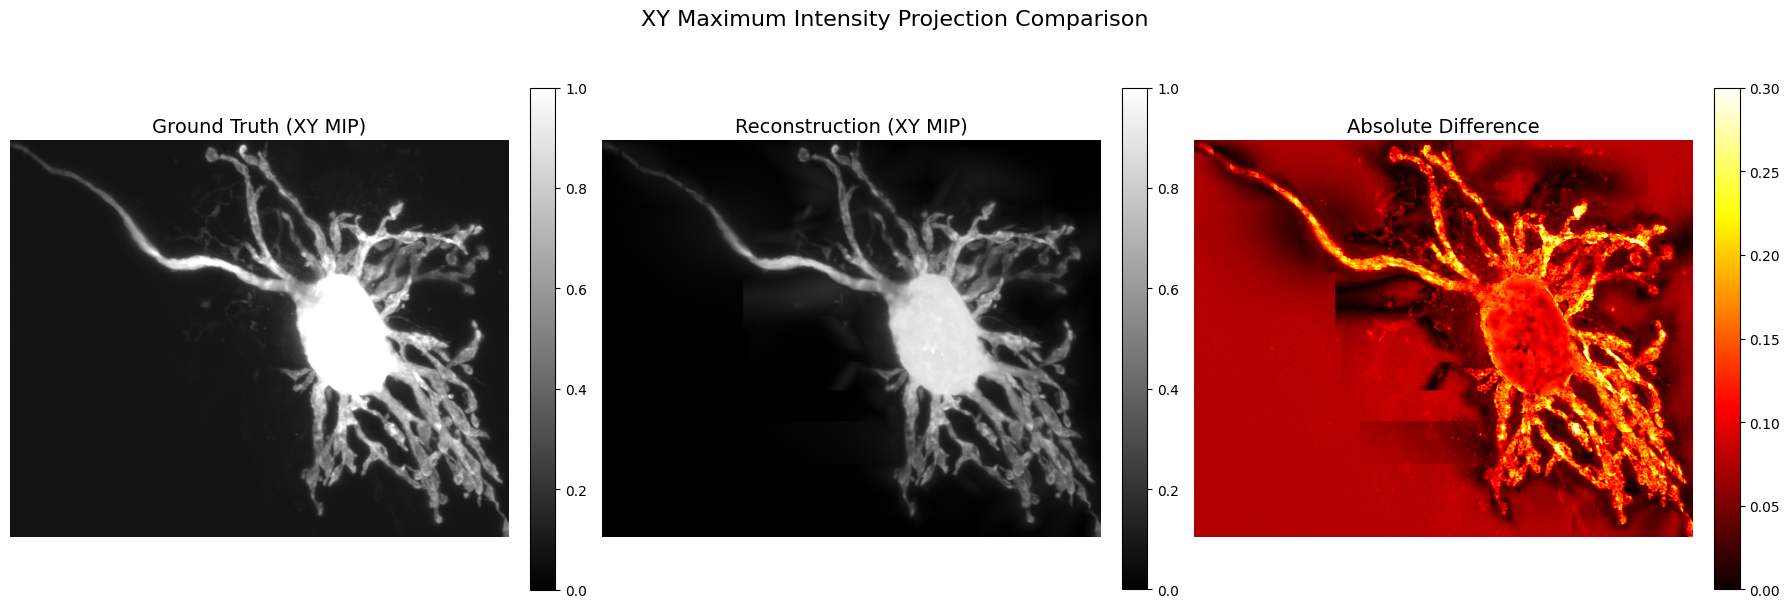


XY MIP PSNR: 21.42 dB
XY MIP MSE: 0.007206


In [2]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt

# Load volumes
gt_vol = tifffile.imread('output/sparse_gate_500k/ground_truth.tif')
recon_vol = tifffile.imread('output/sparse_gate_500k/reconstructed.tif')

print(f"GT shape: {gt_vol.shape}, dtype: {gt_vol.dtype}")
print(f"Recon shape: {recon_vol.shape}, dtype: {recon_vol.dtype}")

# Normalize to [0, 1]
gt_norm = (gt_vol - gt_vol.min()) / (gt_vol.max() - gt_vol.min() + 1e-8)
recon_norm = (recon_vol - recon_vol.min()) / (recon_vol.max() - recon_vol.min() + 1e-8)

# Compute XY MIP (max along Z/depth axis)
gt_xy_mip = gt_norm.max(axis=0)
recon_xy_mip = recon_norm.max(axis=0)
diff_xy_mip = np.abs(gt_xy_mip - recon_xy_mip)

print(f"\nXY MIP shapes: GT={gt_xy_mip.shape}, Recon={recon_xy_mip.shape}")
print(f"Diff range: [{diff_xy_mip.min():.4f}, {diff_xy_mip.max():.4f}]")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

im0 = axes[0].imshow(gt_xy_mip, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Ground Truth (XY MIP)', fontsize=14)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(recon_xy_mip, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Reconstruction (XY MIP)', fontsize=14)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

im2 = axes[2].imshow(diff_xy_mip, cmap='hot', vmin=0, vmax=0.3)
axes[2].set_title('Absolute Difference', fontsize=14)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.suptitle('XY Maximum Intensity Projection Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Statistics
mse = np.mean((gt_xy_mip - recon_xy_mip)**2)
psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')
print(f"\nXY MIP PSNR: {psnr:.2f} dB")
print(f"XY MIP MSE: {mse:.6f}")